<a href="https://colab.research.google.com/github/diegoramfin/Mean-Variance-and-Risk-Parity-Portfolio-Optimizer/blob/main/Mean_Variance_and_Risk_Parity_Portfolio_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean-Variance and Risk Parity Portfolio Optimizer

Project focuses on construction optimal investment portfolios using three powerful and academically grounded techniques. They are: Markowitz Mean Variance Optimization, Black-Litterman Model, and Risk Parity (Inverse Volatility).

In [43]:
%pip install riskfolio-lib
%pip install bt
!pip install --upgrade riskfolio-lib


In [44]:
import yfinance as yf
import pandas as pd

def download_price_data(tickers, start_date, end_date):
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Adj Close"]
    return df.dropna()

In [45]:
#Markowitz Portfolio Optimization

import numpy as np
import cvxpy as cp

def markowitz_optimizer(returns):
    mu = returns.mean()
    cov = returns.cov()
    tickers = returns.columns
    n = len(tickers)

    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    gamma.value = 1

    # Convert mu to a NumPy array to ensure compatibility with cvxpy operations
    objective = cp.Maximize(np.array(mu) @ w - gamma * cp.quad_form(w, cov))
    constraints = [cp.sum(w) == 1, w >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is None:
        return pd.Series(np.zeros(n), index=tickers)

    return pd.Series(w.value, index=tickers)

In [46]:
#Risk Parity Optimization

def risk_parity_weights(returns):
    vol = returns.std()
    inv_vol = 1 / vol
    weights = inv_vol / inv_vol.sum()
    return weights

In [48]:
import numpy as np
import yfinance as yf
import riskfolio as rp

def black_litterman_optimizer(returns):
    tickers = returns.columns.tolist()

    # Market capitalization weights (mocked or from yfinance)
    caps = [yf.Ticker(t).info.get('marketCap', 1e9) for t in tickers]
    market_caps = np.array(caps, dtype=np.float64)
    market_weights = market_caps / market_caps.sum()

    # Calculate sample mean and covariance
    port = rp.Portfolio(returns=returns)
    port.assets_stats(method_mu='hist', method_cov='hist')
    cov = port.cov
    mu = port.mu.values.flatten()

    # Risk aversion (delta)
    market_return = np.dot(market_weights, mu)
    market_vol = np.sqrt(np.dot(market_weights.T, np.dot(cov, market_weights)))
    delta = market_return / (market_vol ** 2)

    # Compute Black-Litterman implied returns manually
    tau = 0.05  # Scalar for uncertainty in the prior
    pi = delta * np.dot(cov, market_weights)  # Implied equilibrium returns

    # No views, so posterior = prior
    bl_mu = pi

    # Set and optimize
    port.mu = bl_mu
    weights = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=delta)
    return weights.T.iloc[0]



In [49]:
#Backtest Engine

import bt

def create_strategy(name, price_data, optimizer_func):
    class CustomWeigh(bt.Algo):
        def __call__(self, target):
            prices = target.universe
            returns = prices.pct_change().dropna()


            if returns.shape[0] < 21 or returns.isnull().values.any():
                print(f"[{name}] Skipping rebalance: insufficient data")
                return False

            weights = optimizer_func(returns)


            if weights.isnull().any() or (weights.sum() == 0):
                print(f"[{name}] Optimizer returned invalid weights")
                return False

            target.temp['weights'] = weights
            return True

    strategy = bt.Strategy(name, [
        bt.algos.RunAfterDays(30),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        CustomWeigh(),
        bt.algos.Rebalance() # Removed WeighTarget and rely on CustomWeigh setting target.temp['weights']
    ])
    return strategy


def run_all_backtests(price_data):
    strategies = [
        create_strategy("Markowitz", price_data, markowitz_optimizer),
        create_strategy("RiskParity", price_data, risk_parity_weights),
        create_strategy("BlackLitterman", price_data, black_litterman_optimizer),
    ]

    backtests = [bt.Backtest(s, price_data) for s in strategies]
    results = bt.run(*backtests)
    results.plot(title="Portfolio Strategies Performance")
    return results

[*********************100%***********************]  8 of 8 completed
100%|██████████| 3/3 [00:59<00:00, 19.89s/it]


Stat                 Markowitz    RiskParity    BlackLitterman
-------------------  -----------  ------------  ----------------
Start                2018-01-01   2018-01-01    2018-01-01
End                  2024-12-30   2024-12-30    2024-12-30
Risk-free rate       0.00%        0.00%         0.00%

Total Return         730.86%      433.19%       855.68%
Daily Sharpe         0.91         1.11          1.25
Daily Sortino        1.50         1.76          2.04
CAGR                 35.35%       27.03%        38.08%
Max Drawdown         -64.80%      -37.41%       -37.79%
Calmar Ratio         0.55         0.72          1.01

MTD                  6.01%        2.05%         3.88%
3m                   26.02%       11.15%        11.90%
6m                   32.95%       15.25%        14.39%
YTD                  126.96%      41.13%        62.92%
1Y                   126.96%      41.13%        62.92%
3Y (ann.)            24.27%       21.51%        28.01%
5Y (ann.)            53.44%       31.32%   

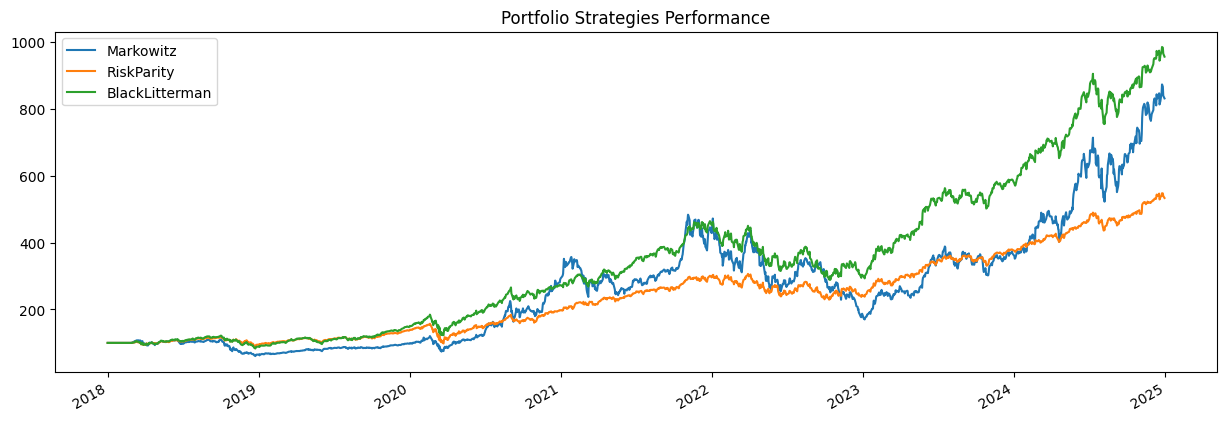

In [50]:
if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'JPM', 'V', 'XOM', 'NVDA']
    data = download_price_data(tickers, start_date="2018-01-01", end_date="2024-12-31")
    results = run_all_backtests(data)
    print(results.display())
